# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Edmonton, Alberta

### 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install folium
!pip install geocoder

Importing Libraries

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries are Done!")

All Required Libraries are Done!


### 2. Data Extraction and Cleaning

Extract Data of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T

In [3]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T"
wikitable=pd.read_html(url,attrs={"class": "wikitable"})

alberta = wikitable[0]
alberta.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


Proceed to clean data from Dataframe

In [4]:
# clean dataframe 

#Borough

alberta = alberta[alberta.Borough!='Not assigned']
alberta = alberta[alberta.Borough!= 0]
alberta.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,alberta.shape[0]):
    if alberta.iloc[i][2] == 'Not assigned':
        alberta.iloc[i][2] = alberta.iloc[i][1]
        i = i+1
        
#Latitude

alberta = alberta[alberta.Latitude!='Not assigned']
alberta = alberta[alberta.Latitude!= 0]
alberta.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,alberta.shape[0]):
    if alberta.iloc[i][4] == 'Not assigned':
        alberta.iloc[i][4] = alberta.iloc[i][1]
        i = i+1

In [5]:
df = alberta.groupby(['Postal Code','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postal Code,Borough,Neighborhood
0,T1A,Medicine Hat,Central Medicine Hat
1,T1B,Medicine Hat,South Medicine Hat
2,T1C,Medicine Hat,North Medicine Hat
3,T1G,Taber,Taber
4,T1H,Lethbridge,North Lethbridge


In [6]:
df.describe()

,Postal Code,Borough,Neighborhood
count,138,138,138
unique,138,52,137
top,T4E,Edmonton,"Southgate, North Riverbend"
freq,1,38,2


In [7]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df["Postal Code"] != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [8]:
df.head()

,Postal Code,Borough,Neighborhood
0,T1A,Medicine Hat,Central Medicine Hat
1,T1B,Medicine Hat,South Medicine Hat
2,T1C,Medicine Hat,North Medicine Hat
3,T1G,Taber,Taber
4,T1H,Lethbridge,North Lethbridge


In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postal Code', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [10]:
df_2.describe()

,Postal Code,Borough,Neighborhood
count,138,138,138
unique,138,52,137
top,T4E,Edmonton,"Southgate, North Riverbend"
freq,1,38,2


In [11]:
print(df_2.shape)
df_2.head()

(138, 3)


,Postal Code,Borough,Neighborhood
0,T1A,Medicine Hat,Central Medicine Hat
1,T1B,Medicine Hat,South Medicine Hat
2,T1C,Medicine Hat,North Medicine Hat
3,T1G,Taber,Taber
4,T1H,Lethbridge,North Lethbridge


In [12]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Alberta, Canada'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('T5A')

[53.59445000000005, -113.40859999999998]

In [13]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postal Code']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [14]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [15]:
df_2[df_2["Postal Code"] == 'T5A']

,Postal Code,Borough,Neighborhood,Latitude,Longitude
65,T5A,Edmonton,"West Clareview, East Londonderry",53.59445,-113.4086


Create DataFrame for Edmonton

In [16]:
df_2=df_2[df_2["Borough"] == 'Edmonton'].reset_index(drop=True)
print(df_2.shape)
df_2.head()

(38, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T5A,Edmonton,"West Clareview, East Londonderry",53.59445,-113.40860
1,T5B,Edmonton,"East North Central, West Beverly",53.56974,-113.46277
2,T5C,Edmonton,Central Londonderry,53.59958,-113.45311
3,T5E,Edmonton,"West Londonderry, East Calder",53.59936,-113.49765
4,T5G,Edmonton,"North Central, Queen Mary Park, Blatchford",53.57146,-113.50617


In [17]:
address = 'Edmonton,Alberta'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude


### 3. Map of Edmonton

In [18]:
map_Edmonton = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Edmonton)  
    
map_Edmonton

In [19]:
address = 'Edmonton,Alberta'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 53.535411, -113.507996.


In [20]:
# @hiddel_cell
CLIENT_ID = 'LYHSD4MP2HTXLHTAWEKOJGCNLMVC3VJOJMUKWALXDUDVZFV0' # my Foursquare ID
CLIENT_SECRET = '545W2OJFTN3WWMQJEDSEYRUI3KIR0ITJMEKJ3VQKYR4GEKIP' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: LYHSD4MP2HTXLHTAWEKOJGCNLMVC3VJOJMUKWALXDUDVZFV0
CLIENT_SECRET: 545W2OJFTN3WWMQJEDSEYRUI3KIR0ITJMEKJ3VQKYR4GEKIP


In [21]:
radius = 1000 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [22]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [24]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Legislature Grounds,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",53.534614,-113.506071
1,The Common,"[{'id': '4bf58dd8d48988d11f941735', 'name': 'N...",53.537635,-113.508570
2,Zuppa Cafe,"[{'id': '4bf58dd8d48988d143941735', 'name': 'B...",53.537059,-113.509847
3,District Coffee Co,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",53.538903,-113.508257
4,Constable Ezio Faraone Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",53.533641,-113.511086


### 5. Categories of Nearby Venues/Locations

In [25]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Legislature Grounds,Park,53.534614,-113.506071
1,The Common,Nightclub,53.537635,-113.508570
2,Zuppa Cafe,Breakfast Spot,53.537059,-113.509847
3,District Coffee Co,Café,53.538903,-113.508257
4,Constable Ezio Faraone Park,Park,53.533641,-113.511086


Top 10 Categories

In [26]:

a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Sandwich Place        6
Coffee Shop           5
Café                  5
Italian Restaurant    5
Nightclub             4
Park                  3
Hotel                 3
Convenience Store     3
Pub                   3
Bar                   3
Name: categories, dtype: int64

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Nearby Venues

In [28]:

Edmonton_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

West Clareview, East Londonderry
East North Central, West Beverly
Central Londonderry
West Londonderry, East Calder
North Central, Queen Mary Park, Blatchford
NorthDowntown Fringe, East Downtown Fringe
North Downtown
South Downtown, South Downtown Fringe (Alberta Provincial Government)
North Westmount, West Calder, East Mistatim
South Westmount, Groat Estate, East Northwest Industrial
Glenora, SW Downtown Fringe
North Jasper Place
Central Jasper Place, Buena Vista
West Northwest Industrial, Winterburn
West Jasper Place, West Edmonton Mall
Central Mistatim
Central Beverly
East Castledowns
Horse Hill, East Lake District
West Lake District
North Capilano
SE Capilano, West Southeast Industrial, East Bonnie Doon
Central Bonnie Doon
South Bonnie Doon, East University
West University, Strathcona Place
Southgate, North Riverbend
Kaskitayo, Aspen Gardens
West Mill Woods
East Mill Woods
Southwest Edmonton
South Industrial
East Southeast Industrial, South Clover Bar
Southgate, North Riverbend
Nor

In [29]:
print('There are {} Uniques Categories.'.format(len(Edmonton_venues['Venue Category'].unique())))
Edmonton_venues.groupby('Neighborhood').count().head()

There are 145 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Central Beverly,8,8,8,8,8,8
Central Bonnie Doon,24,24,24,24,24,24
"Central Jasper Place, Buena Vista",5,5,5,5,5,5
Central Londonderry,21,21,21,21,21,21
East Castledowns,4,4,4,4,4,4


### One Hot Encoding of Features

In [30]:
# one hot encoding
Edmonton_onehot = pd.get_dummies(Edmonton_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Edmonton_onehot['Neighborhood'] = Edmonton_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Edmonton_onehot.columns[-1]] + list(Edmonton_onehot.columns[:-1])
Edmonton_onehot = Edmonton_onehot[fixed_columns]
Edmonton_grouped = Edmonton_onehot.groupby('Neighborhood').mean().reset_index()
Edmonton_onehot.head(50)

,Neighborhood,Airport Lounge,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,College Cafeteria,College Gym,College Residence Hall,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,Hockey Arena,Home Service,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Inn,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Museum,Music Store,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Racetrack,Recreation Center,Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Smoothie Shop,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Shop,Yoga Studio
0,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"West Clareview, East Londonderry",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"West Clareview, East Londonderry",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [31]:
num_top_venues = 10
for hood in Edmonton_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Edmonton_grouped[Edmonton_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Central Beverly ----
                  venue  freq
0                 Diner  0.25
1     Convenience Store  0.12
2            Donut Shop  0.12
3              Pharmacy  0.12
4                Bakery  0.12
5  Fast Food Restaurant  0.12
6                  Park  0.12
7  Outdoor Supply Store  0.00
8             Nightclub  0.00
9          Noodle House  0.00


---- Central Bonnie Doon ----
                   venue  freq
0  Vietnamese Restaurant  0.08
1                   Bank  0.08
2            Coffee Shop  0.08
3              Gift Shop  0.04
4                Theater  0.04
5            Pizza Place  0.04
6               Pharmacy  0.04
7              Irish Pub  0.04
8   Fast Food Restaurant  0.04
9      Convenience Store  0.04


---- Central Jasper Place, Buena Vista ----
                     venue  freq
0                     Café   0.2
1         Sushi Restaurant   0.2
2                     Park   0.2
3                   Bakery   0.2
4           Sandwich Place   0.2
5           Airport Lounge 

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [33]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Edmonton_grouped['Neighborhood']

for ind in np.arange(Edmonton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Edmonton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Beverly,Diner,Convenience Store,Park,Donut Shop,Bakery,Pharmacy,Fast Food Restaurant,Dessert Shop,Discount Store,Dive Bar
1,Central Bonnie Doon,Bank,Vietnamese Restaurant,Coffee Shop,Convenience Store,Japanese Restaurant,French Restaurant,Breakfast Spot,Irish Pub,Bowling Alley,Bookstore
2,"Central Jasper Place, Buena Vista",Park,Café,Sushi Restaurant,Sandwich Place,Bakery,Yoga Studio,Eastern European Restaurant,Falafel Restaurant,Factory,Event Space
3,Central Londonderry,Department Store,Coffee Shop,Clothing Store,Fast Food Restaurant,Sporting Goods Shop,Gym / Fitness Center,Thai Restaurant,Pharmacy,Sandwich Place,Shoe Store
4,East Castledowns,Park,Mediterranean Restaurant,Shopping Plaza,Dessert Shop,Department Store,Diner,Discount Store,Dive Bar,Doner Restaurant,Fish & Chips Shop


### K-Means Clustering Approach

Using K-Means to cluster neighborhood into 10 clusters

In [34]:
Edmonton_grouped_clustering = Edmonton_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=10, random_state=0).fit(Edmonton_grouped_clustering)
kmeans.labels_[0:10] 

array([3, 3, 3, 1, 7, 1, 3, 3, 3, 9], dtype=int32)

In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Edmonton_merged =df_2.iloc[:16,:]

Edmonton_merged = Edmonton_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


Edmonton_merged = Edmonton_merged.drop(Edmonton_merged[Edmonton_merged['Postal Code']=="T5V"].index)
Edmonton_merged['Cluster Labels'] = Edmonton_merged['Cluster Labels'].apply(np.int32)
Edmonton_merged.head()# check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T5A,Edmonton,"West Clareview, East Londonderry",53.59445,-113.40860,3,Grocery Store,Pizza Place,Portuguese Restaurant,Sandwich Place,Clothing Store,Coffee Shop,Restaurant,Electronics Store,Mexican Restaurant,Gym
1,T5B,Edmonton,"East North Central, West Beverly",53.56974,-113.46277,3,Pizza Place,Supermarket,Inn,Fast Food Restaurant,Light Rail Station,Lounge,Nightclub,Pharmacy,Racetrack,Coffee Shop
2,T5C,Edmonton,Central Londonderry,53.59958,-113.45311,1,Department Store,Coffee Shop,Clothing Store,Fast Food Restaurant,Sporting Goods Shop,Gym / Fitness Center,Thai Restaurant,Pharmacy,Sandwich Place,Shoe Store
3,T5E,Edmonton,"West Londonderry, East Calder",53.59936,-113.49765,3,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Pharmacy,Pizza Place,Dessert Shop,Gym,Department Store,Discount Store,Chinese Restaurant
4,T5G,Edmonton,"North Central, Queen Mary Park, Blatchford",53.57146,-113.50617,3,Airport Lounge,Discount Store,Asian Restaurant,Dive Bar,Optical Shop,BBQ Joint,Thrift / Vintage Store,College Cafeteria,Coffee Shop,Electronics Store


### Map of Clusters

In [37]:
kclusters = 10

Create the map for Clusters                                                     

In [39]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Edmonton_merged['Latitude'], Edmonton_merged['Longitude'], Edmonton_merged['Neighborhood'], Edmonton_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
df1=Edmonton_merged.loc[Edmonton_merged['Cluster Labels'] == 1,Edmonton_merged.columns[[2] + list(range(5, Edmonton_merged.shape[1]))]]
df2=Edmonton_merged.loc[Edmonton_merged['Cluster Labels'] == 3,Edmonton_merged.columns[[2] + list(range(5, Edmonton_merged.shape[1]))]]
df3=Edmonton_merged.loc[Edmonton_merged['Cluster Labels'] == 7,Edmonton_merged.columns[[2] + list(range(5, Edmonton_merged.shape[1]))]]
df4=Edmonton_merged.loc[Edmonton_merged['Cluster Labels'] == 9,Edmonton_merged.columns[[2] + list(range(5, Edmonton_merged.shape[1]))]]

In [42]:
Edmonton_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0                                                        
                                                              
                                                              ]})

In [43]:
Edmonton_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

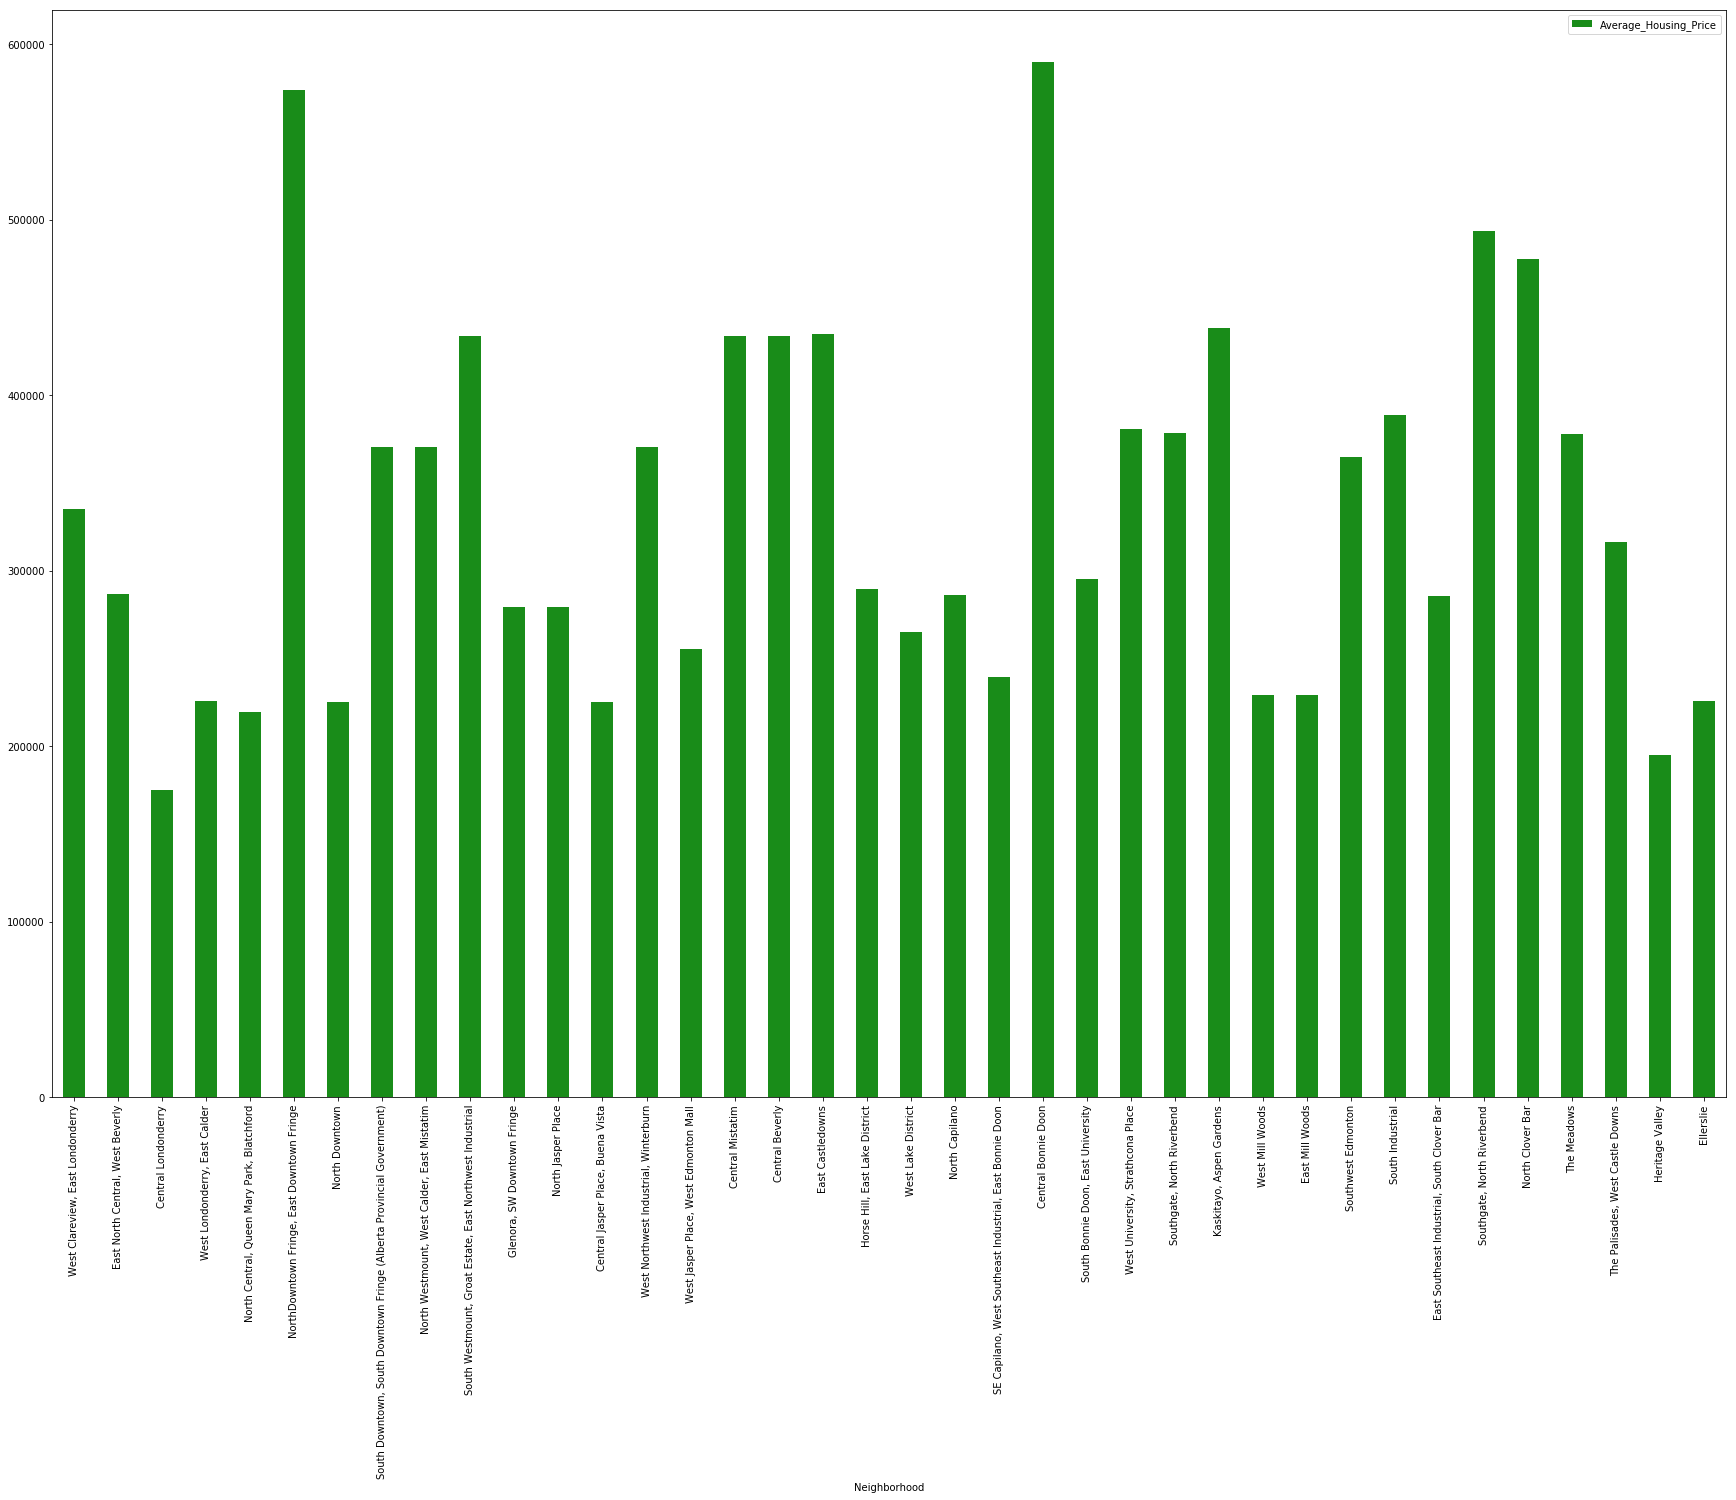

In [46]:
Edmonton_Avg_HousingPrice.plot(kind='bar',figsize=(30,20),color='green',alpha=0.9)

In [47]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster3":df3["Neighborhood"],
                      "Cluster3":df4["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [49]:
New_Edmonton=Edmonton_merged.set_index("Neighborhood",drop=True)
#Source:https://www.compareschoolrankings.org/
Edmonton_school_ratings=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8]})

In [50]:
Edmonton_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

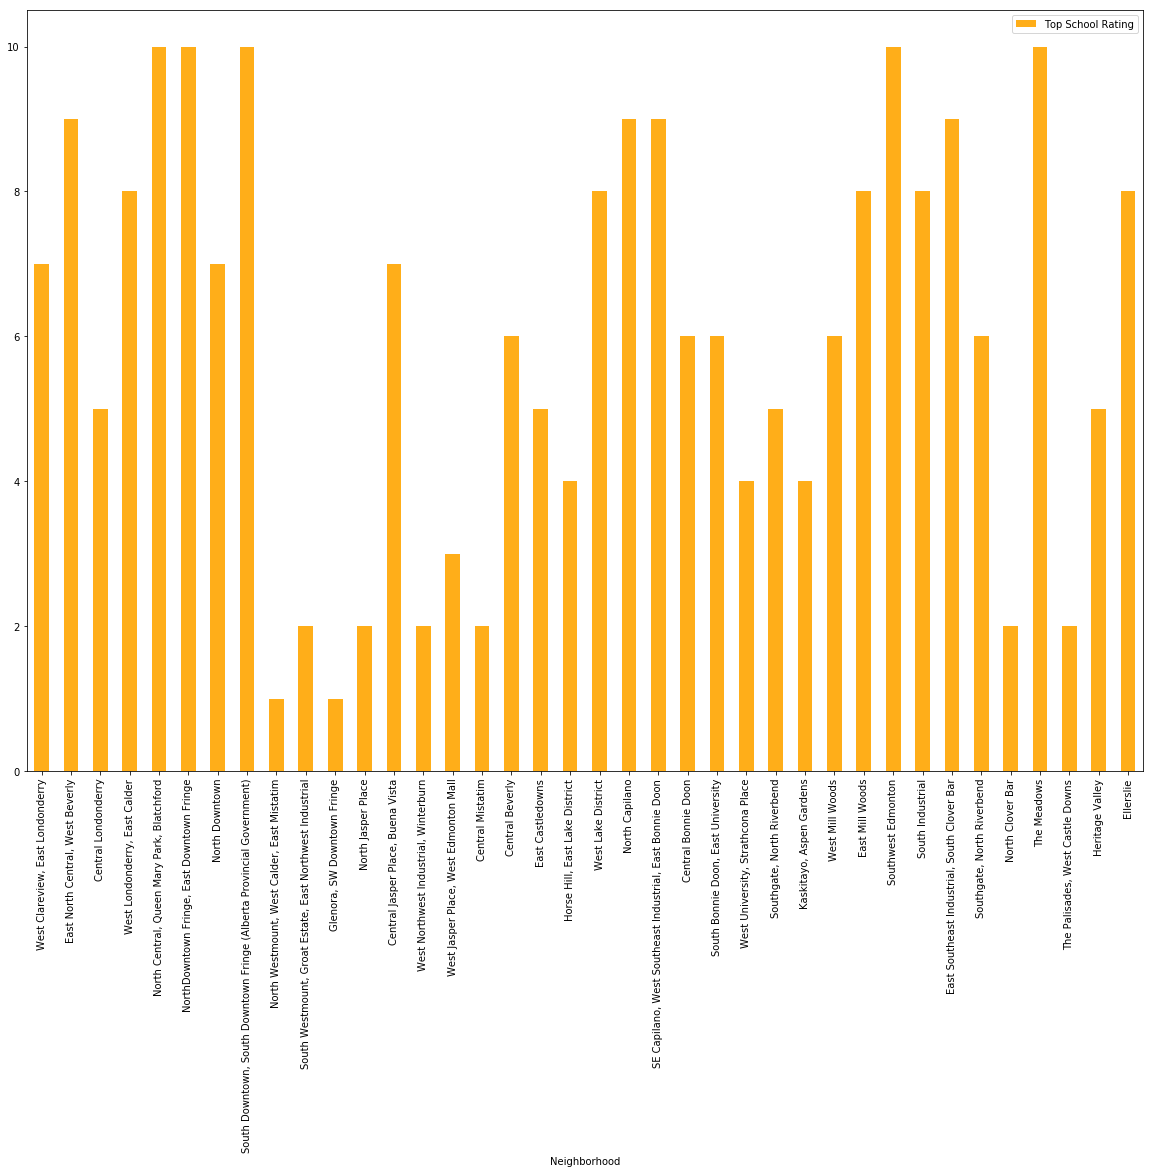

In [51]:
Edmonton_school_ratings.plot(kind='bar',figsize=(20,14),color='orange',alpha=0.9);